# Notebook 02: Feature Engineering

**Objective**: Create and analyze engineered features from raw sensor data

**Contents**:
1. Load processed features
2. Visualize feature distributions
3. Analyze feature importance
4. Prepare data for modeling
5. Save final dataset

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print("✓ Libraries imported successfully")

✓ Libraries imported successfully


## 1. Load Featured Data

In [2]:
# Load the engineered features
df = pd.read_csv('../data/processed/featured_sensor_data.csv')

print(f"Dataset shape: {df.shape}")
print(f"\nColumns: {len(df.columns)}")
print(f"Samples: {len(df)}")
print(f"\nAnomaly distribution:")
print(df['anomaly'].value_counts())
print(f"\nAnomaly ratio: {df['anomaly'].mean():.2%}")

Dataset shape: (10000, 128)

Columns: 128
Samples: 10000

Anomaly distribution:
anomaly
0    9575
1     425
Name: count, dtype: int64

Anomaly ratio: 4.25%


In [3]:
# Display feature categories
feature_cols = df.columns.tolist()

time_features = [col for col in feature_cols if any(x in col for x in ['hour', 'day', 'weekend', 'night', 'morning', 'afternoon', 'evening', 'month'])]
rolling_features = [col for col in feature_cols if 'rolling' in col]
lag_features = [col for col in feature_cols if 'lag' in col]
diff_features = [col for col in feature_cols if 'diff' in col or 'pct_change' in col]
interaction_features = [col for col in feature_cols if 'ratio' in col or 'sensors_' in col]
sensor_features = ['sensor_1', 'sensor_2', 'sensor_3', 'sensor_4']

print(f"Original sensor features: {len(sensor_features)}")
print(f"Time features: {len(time_features)}")
print(f"Rolling features: {len(rolling_features)}")
print(f"Lag features: {len(lag_features)}")
print(f"Difference features: {len(diff_features)}")
print(f"Interaction features: {len(interaction_features)}")
print(f"\nTotal feature count: {len(feature_cols)}")

Original sensor features: 4
Time features: 13
Rolling features: 60
Lag features: 16
Difference features: 22
Interaction features: 11

Total feature count: 128


## 2. Visualize Key Features

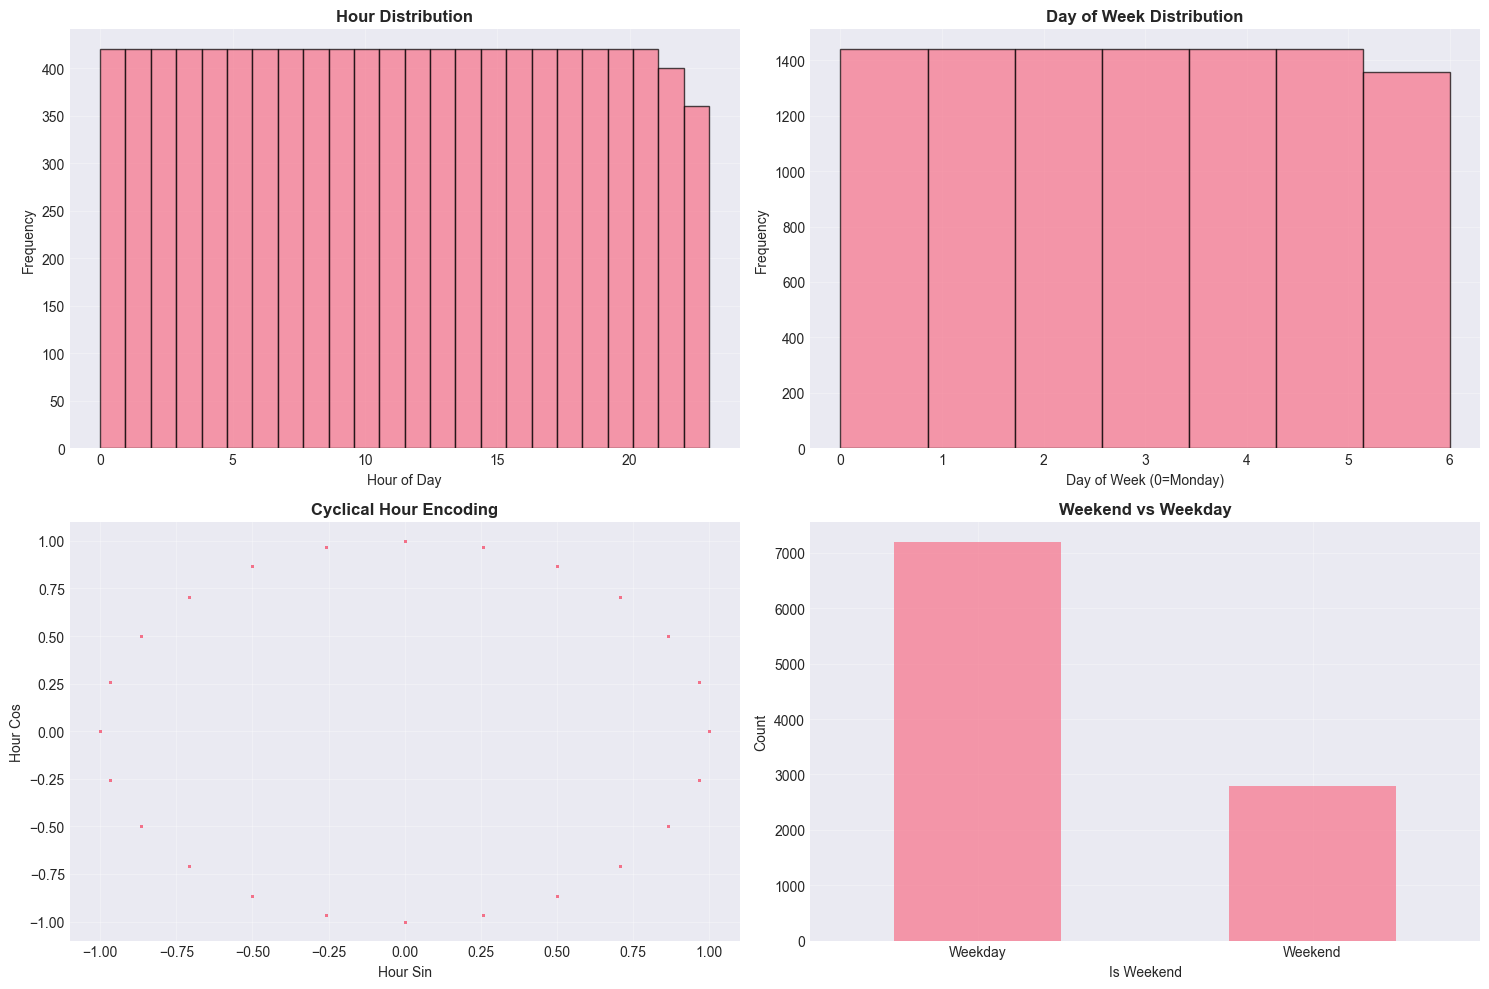

✓ Plot saved to outputs/plots/04_time_features.png


In [5]:
# Plot time features distribution
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Hour distribution
axes[0, 0].hist(df['hour'], bins=24, alpha=0.7, edgecolor='black')
axes[0, 0].set_xlabel('Hour of Day')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Hour Distribution', fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)

# Day of week distribution
axes[0, 1].hist(df['day_of_week'], bins=7, alpha=0.7, edgecolor='black')
axes[0, 1].set_xlabel('Day of Week (0=Monday)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Day of Week Distribution', fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

# Cyclical hour encoding
axes[1, 0].scatter(df['hour_sin'], df['hour_cos'], alpha=0.3, s=1)
axes[1, 0].set_xlabel('Hour Sin')
axes[1, 0].set_ylabel('Hour Cos')
axes[1, 0].set_title('Cyclical Hour Encoding', fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# Weekend indicator
df['is_weekend'].value_counts().plot(kind='bar', ax=axes[1, 1], alpha=0.7)
axes[1, 1].set_xlabel('Is Weekend')
axes[1, 1].set_ylabel('Count')
axes[1, 1].set_title('Weekend vs Weekday', fontweight='bold')
axes[1, 1].set_xticklabels(['Weekday', 'Weekend'], rotation=0)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../outputs/plots/04_time_features.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Plot saved to outputs/plots/04_time_features.png")

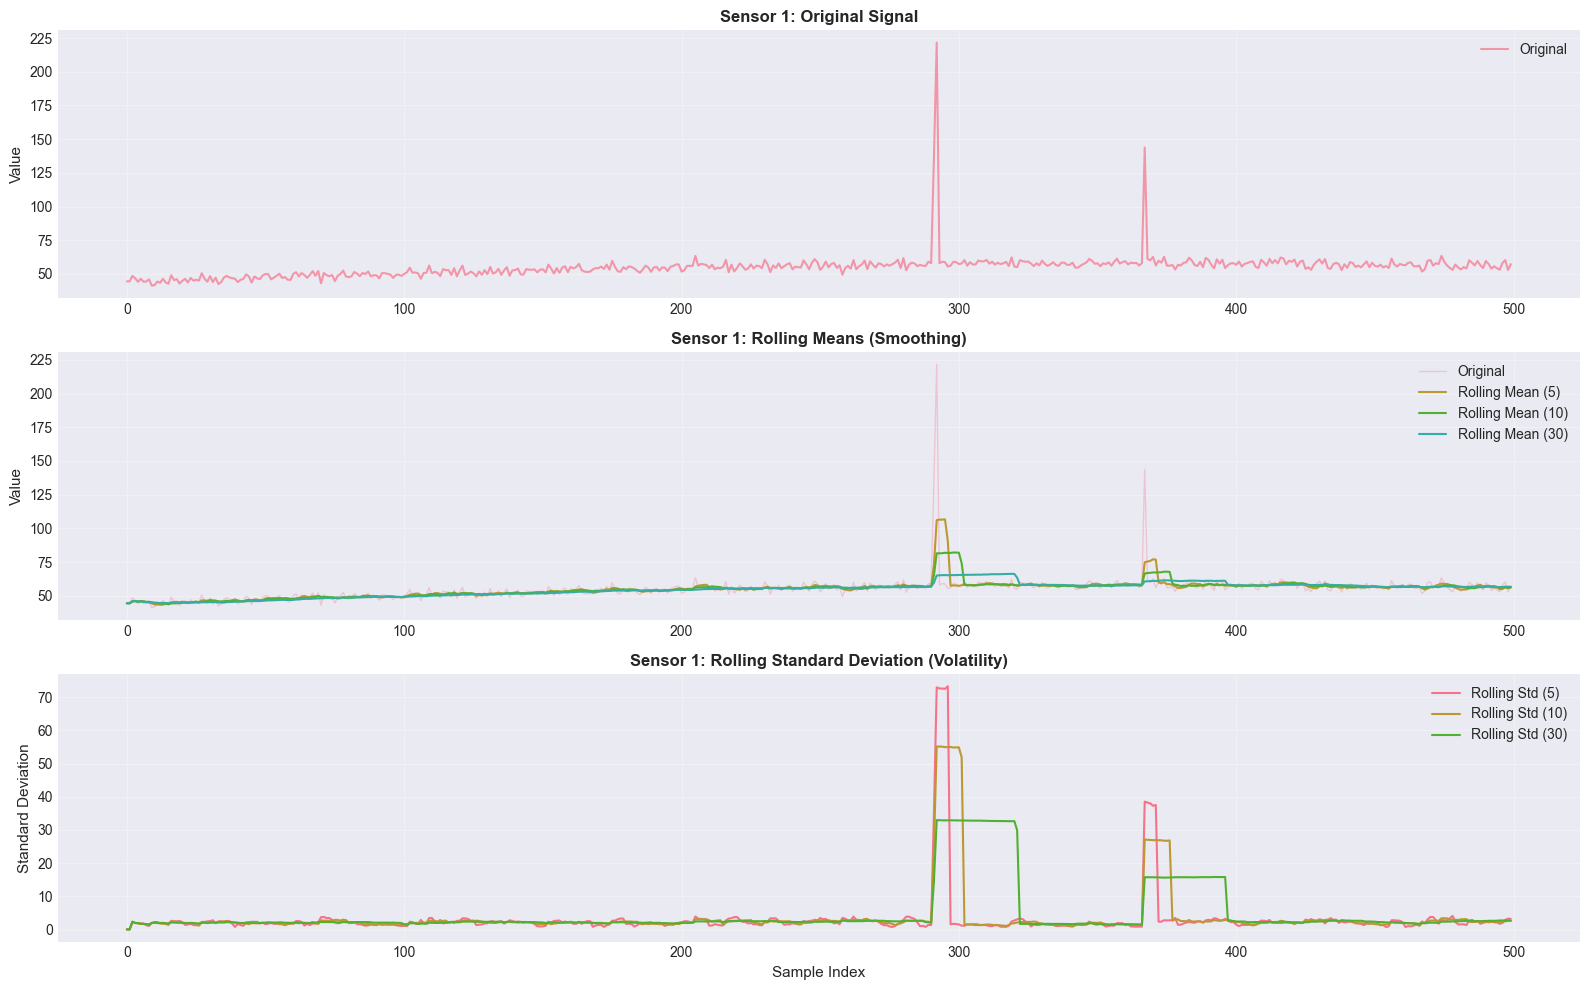

✓ Plot saved to outputs/plots/05_rolling_features.png


In [7]:
    # Compare original vs rolling features for one sensor
    sample_size = 500
    sample_df = df.head(sample_size)
    
    fig, axes = plt.subplots(3, 1, figsize=(16, 10))
    
    # Original sensor data
    axes[0].plot(sample_df.index, sample_df['sensor_1'], label='Original', alpha=0.7, linewidth=1.5)
    axes[0].set_ylabel('Value', fontsize=11)
    axes[0].set_title('Sensor 1: Original Signal', fontsize=12, fontweight='bold')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Rolling means
    axes[1].plot(sample_df.index, sample_df['sensor_1'], label='Original', alpha=0.3, linewidth=1)
    axes[1].plot(sample_df.index, sample_df['sensor_1_rolling_mean_5'], label='Rolling Mean (5)', linewidth=1.5)
    axes[1].plot(sample_df.index, sample_df['sensor_1_rolling_mean_10'], label='Rolling Mean (10)', linewidth=1.5)
    axes[1].plot(sample_df.index, sample_df['sensor_1_rolling_mean_30'], label='Rolling Mean (30)', linewidth=1.5)
    axes[1].set_ylabel('Value', fontsize=11)
    axes[1].set_title('Sensor 1: Rolling Means (Smoothing)', fontsize=12, fontweight='bold')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    # Rolling standard deviation (volatility)
    axes[2].plot(sample_df.index, sample_df['sensor_1_rolling_std_5'], label='Rolling Std (5)', linewidth=1.5)
    axes[2].plot(sample_df.index, sample_df['sensor_1_rolling_std_10'], label='Rolling Std (10)', linewidth=1.5)
    axes[2].plot(sample_df.index, sample_df['sensor_1_rolling_std_30'], label='Rolling Std (30)', linewidth=1.5)
    axes[2].set_xlabel('Sample Index', fontsize=11)
    axes[2].set_ylabel('Standard Deviation', fontsize=11)
    axes[2].set_title('Sensor 1: Rolling Standard Deviation (Volatility)', fontsize=12, fontweight='bold')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('../outputs/plots/05_rolling_features.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("✓ Plot saved to outputs/plots/05_rolling_features.png")

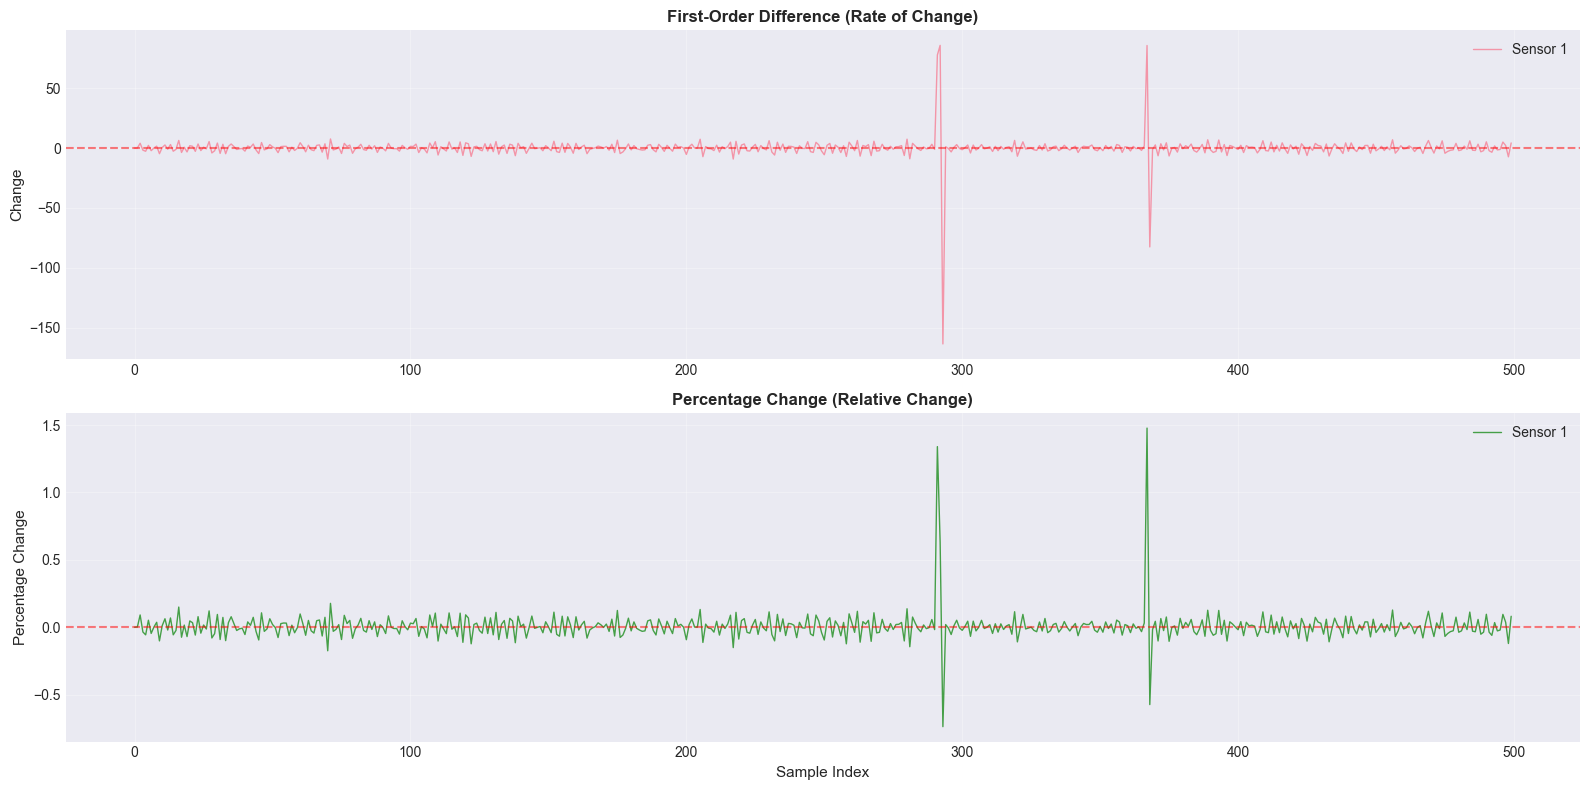

✓ Plot saved to outputs/plots/06_rate_of_change.png


In [8]:
# Visualize rate of change features
sample_size = 500
sample_df = df.head(sample_size)

fig, axes = plt.subplots(2, 1, figsize=(16, 8))

# First difference
axes[0].plot(sample_df.index, sample_df['sensor_1_diff_1'], label='Sensor 1', alpha=0.7, linewidth=1)
axes[0].axhline(y=0, color='red', linestyle='--', linewidth=1.5, alpha=0.5)
axes[0].set_ylabel('Change', fontsize=11)
axes[0].set_title('First-Order Difference (Rate of Change)', fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Percentage change
axes[1].plot(sample_df.index, sample_df['sensor_1_pct_change'], label='Sensor 1', alpha=0.7, linewidth=1, color='green')
axes[1].axhline(y=0, color='red', linestyle='--', linewidth=1.5, alpha=0.5)
axes[1].set_xlabel('Sample Index', fontsize=11)
axes[1].set_ylabel('Percentage Change', fontsize=11)
axes[1].set_title('Percentage Change (Relative Change)', fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../outputs/plots/06_rate_of_change.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Plot saved to outputs/plots/06_rate_of_change.png")

## 3. Feature Importance Analysis

In [9]:
# Prepare data for feature importance
# Select only numeric features (exclude timestamp and anomaly)
feature_columns = [col for col in df.columns if col not in ['timestamp', 'anomaly']]
X = df[feature_columns]
y = df['anomaly']

print(f"Feature matrix shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nClass distribution:")
print(y.value_counts())

Feature matrix shape: (10000, 126)
Target shape: (10000,)

Class distribution:
anomaly
0    9575
1     425
Name: count, dtype: int64


In [10]:
# Train a Random Forest to get feature importances
print("Training Random Forest for feature importance...")

rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    random_state=42,
    n_jobs=-1
)

rf.fit(X, y)

# Get feature importances
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

print("\n✓ Feature importance calculated")
print("\nTop 20 most important features:")
print(feature_importance.head(20))

Training Random Forest for feature importance...

✓ Feature importance calculated

Top 20 most important features:
                      feature  importance
118    sensor_2_sensor_4_diff    0.088432
117   sensor_2_sensor_4_ratio    0.039853
42   sensor_2_rolling_mean_30    0.039350
119   sensor_3_sensor_4_ratio    0.034180
125             sensors_range    0.031794
122               sensors_std    0.027481
62    sensor_4_rolling_mean_5    0.026302
69    sensor_4_rolling_min_10    0.025486
120    sensor_3_sensor_4_diff    0.025018
109   sensor_1_sensor_2_ratio    0.023224
110    sensor_1_sensor_2_diff    0.023215
67   sensor_4_rolling_mean_10    0.022723
64     sensor_4_rolling_min_5    0.022400
37   sensor_2_rolling_mean_10    0.020890
65     sensor_4_rolling_max_5    0.016925
114    sensor_1_sensor_4_diff    0.014873
113   sensor_1_sensor_4_ratio    0.014834
73    sensor_4_rolling_std_30    0.014644
74    sensor_4_rolling_min_30    0.014318
75    sensor_4_rolling_max_30    0.012174


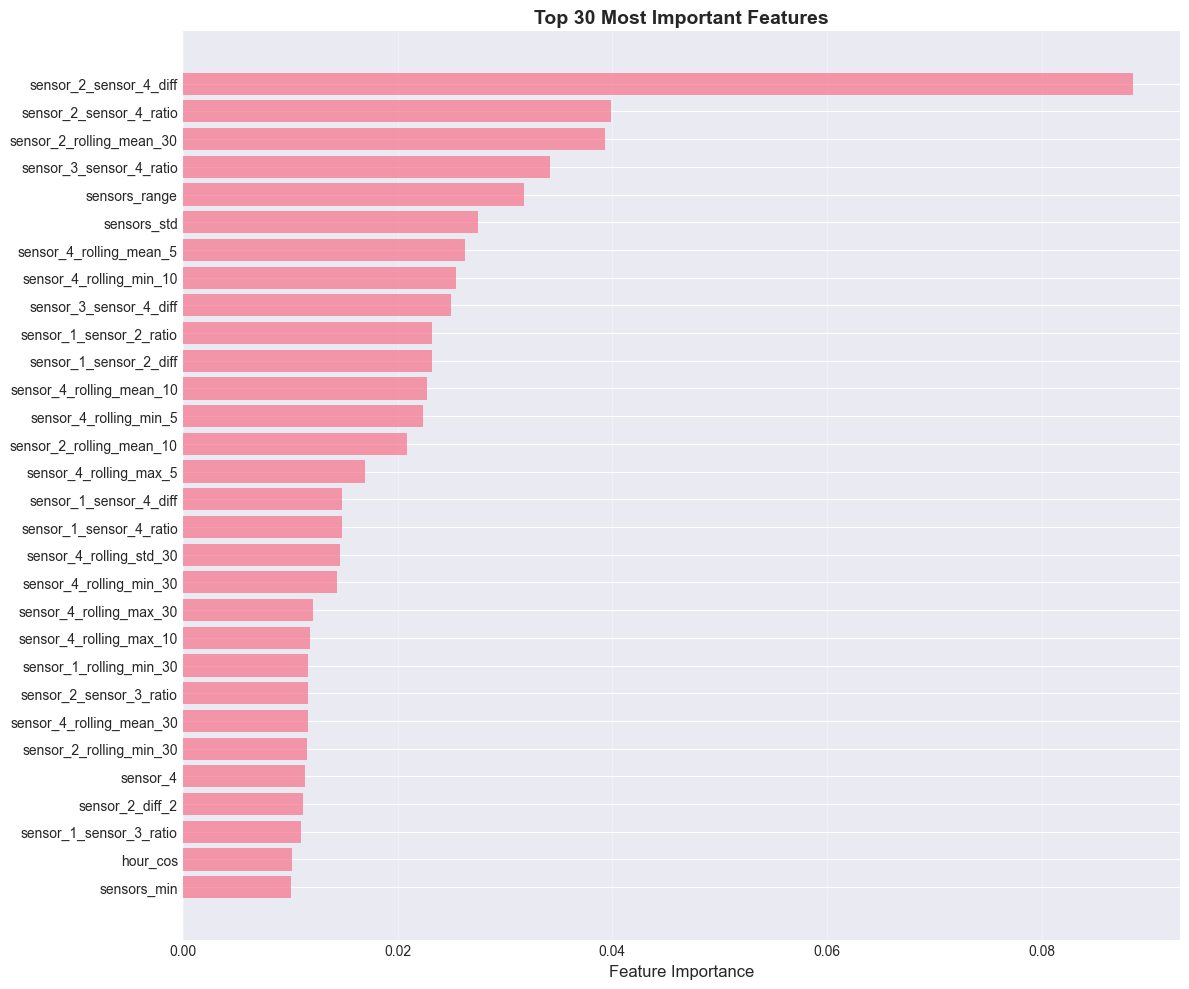

✓ Plot saved to outputs/plots/07_feature_importance.png


In [11]:
# Visualize top 30 features
top_n = 30
top_features = feature_importance.head(top_n)

fig, ax = plt.subplots(figsize=(12, 10))
ax.barh(range(top_n), top_features['importance'], alpha=0.7)
ax.set_yticks(range(top_n))
ax.set_yticklabels(top_features['feature'])
ax.invert_yaxis()
ax.set_xlabel('Feature Importance', fontsize=12)
ax.set_title(f'Top {top_n} Most Important Features', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('../outputs/plots/07_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Plot saved to outputs/plots/07_feature_importance.png")


Feature importance by category:
category
Rolling           0.472037
Interaction       0.218384
Rate of Change    0.210488
Lag               0.047216
Time              0.033576
Original          0.018299
Name: importance, dtype: float64


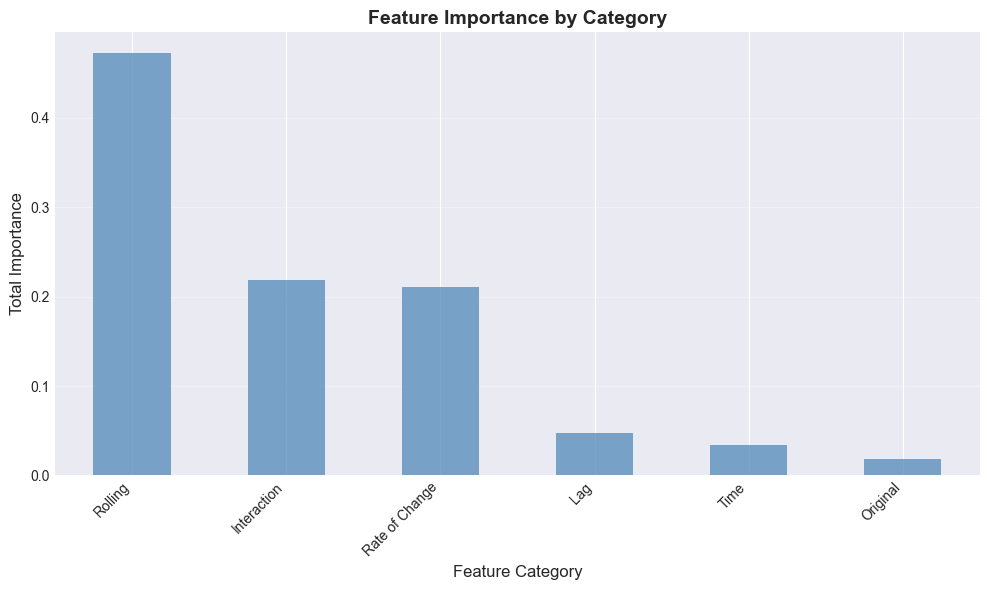

✓ Plot saved to outputs/plots/08_category_importance.png


In [12]:
# Analyze feature importance by category
def categorize_feature(feature_name):
    if any(x in feature_name for x in ['hour', 'day', 'weekend', 'night', 'morning', 'afternoon', 'evening', 'month']):
        return 'Time'
    elif 'rolling' in feature_name:
        return 'Rolling'
    elif 'lag' in feature_name:
        return 'Lag'
    elif 'diff' in feature_name or 'pct_change' in feature_name:
        return 'Rate of Change'
    elif 'ratio' in feature_name or 'sensors_' in feature_name:
        return 'Interaction'
    elif feature_name.startswith('sensor_'):
        return 'Original'
    else:
        return 'Other'

feature_importance['category'] = feature_importance['feature'].apply(categorize_feature)

# Sum importance by category
category_importance = feature_importance.groupby('category')['importance'].sum().sort_values(ascending=False)

print("\nFeature importance by category:")
print(category_importance)

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
category_importance.plot(kind='bar', ax=ax, alpha=0.7, color='steelblue')
ax.set_xlabel('Feature Category', fontsize=12)
ax.set_ylabel('Total Importance', fontsize=12)
ax.set_title('Feature Importance by Category', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.savefig('../outputs/plots/08_category_importance.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Plot saved to outputs/plots/08_category_importance.png")

## 4. Prepare Data for Modeling

In [13]:
# Normalize features using StandardScaler
print("Normalizing features...")

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)

print("✓ Features normalized")
print(f"\nScaled data shape: {X_scaled.shape}")
print("\nFirst 5 rows of scaled data:")
print(X_scaled.head())

Normalizing features...
✓ Features normalized

Scaled data shape: (10000, 126)

First 5 rows of scaled data:
   sensor_1  sensor_2  sensor_3  sensor_4      hour  day_of_week  \
0 -0.812976  0.389229 -0.894586 -0.867153 -1.659421    -1.495605   
1 -0.808440  0.164771 -0.452808  0.102894 -1.659421    -1.495605   
2 -0.478819  0.621484 -0.301165 -0.490393 -1.659421    -1.495605   
3 -0.619818  0.127287 -0.130936 -0.395402 -1.659421    -1.495605   
4 -0.837032  0.599484 -0.758482 -0.763966 -1.659421    -1.495605   

   day_of_month  month  hour_sin  hour_cos  ...  sensor_2_sensor_3_diff  \
0     -1.495605    0.0 -0.003599  1.429376  ...                1.996480   
1     -1.495605    0.0 -0.003599  1.429376  ...                0.961409   
2     -1.495605    0.0 -0.003599  1.429376  ...                1.419571   
3     -1.495605    0.0 -0.003599  1.429376  ...                0.399380   
4     -1.495605    0.0 -0.003599  1.429376  ...                2.103412   

   sensor_2_sensor_4_ratio  sen

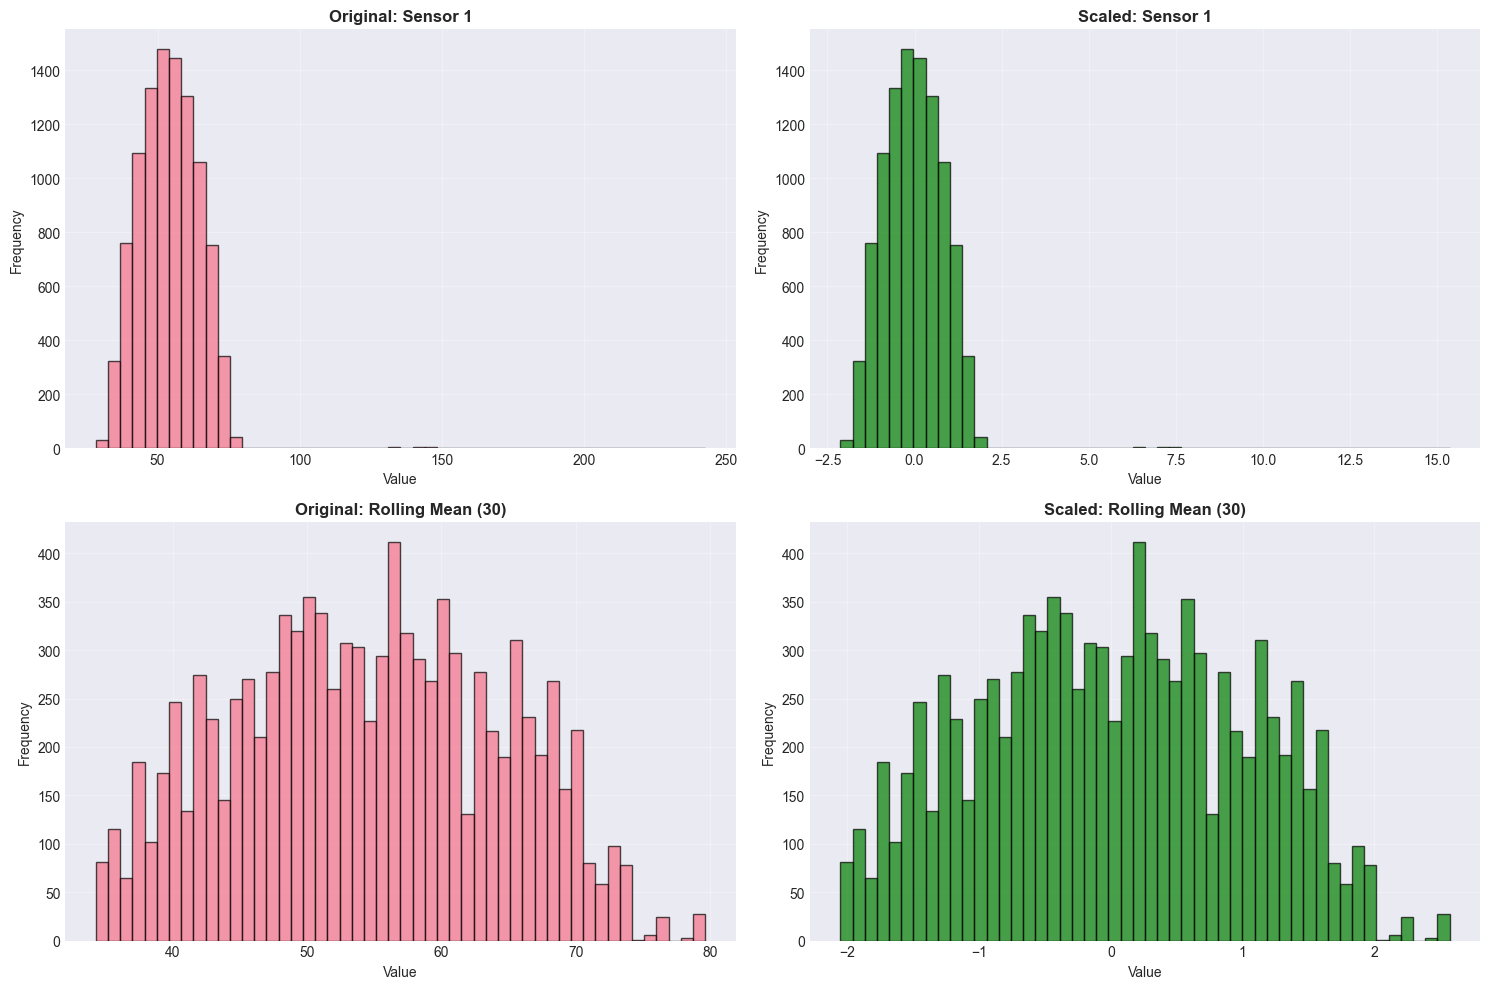

✓ Plot saved to outputs/plots/09_scaling_comparison.png


In [14]:
# Compare original vs scaled distributions
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Original sensor_1
axes[0, 0].hist(X['sensor_1'], bins=50, alpha=0.7, edgecolor='black')
axes[0, 0].set_xlabel('Value')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Original: Sensor 1', fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)

# Scaled sensor_1
axes[0, 1].hist(X_scaled['sensor_1'], bins=50, alpha=0.7, edgecolor='black', color='green')
axes[0, 1].set_xlabel('Value')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Scaled: Sensor 1', fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

# Original rolling mean
axes[1, 0].hist(X['sensor_1_rolling_mean_30'], bins=50, alpha=0.7, edgecolor='black')
axes[1, 0].set_xlabel('Value')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Original: Rolling Mean (30)', fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# Scaled rolling mean
axes[1, 1].hist(X_scaled['sensor_1_rolling_mean_30'], bins=50, alpha=0.7, edgecolor='black', color='green')
axes[1, 1].set_xlabel('Value')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Scaled: Rolling Mean (30)', fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../outputs/plots/09_scaling_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Plot saved to outputs/plots/09_scaling_comparison.png")

## 5. Save Processed Data

In [15]:
# Save scaled features with labels
df_final = X_scaled.copy()
df_final['anomaly'] = y
df_final['timestamp'] = df['timestamp']

# Reorder columns (timestamp and anomaly at the end)
feature_cols_ordered = [col for col in df_final.columns if col not in ['timestamp', 'anomaly']]
df_final = df_final[feature_cols_ordered + ['timestamp', 'anomaly']]

# Save
output_path = '../data/processed/scaled_featured_data.csv'
df_final.to_csv(output_path, index=False)

print(f"✓ Saved scaled featured data to {output_path}")
print(f"\nFinal dataset shape: {df_final.shape}")
print(f"Features: {len(feature_cols_ordered)}")
print(f"Samples: {len(df_final)}")

✓ Saved scaled featured data to ../data/processed/scaled_featured_data.csv

Final dataset shape: (10000, 128)
Features: 126
Samples: 10000


In [16]:
# Save feature importance for later use
feature_importance.to_csv('../outputs/results/feature_importance.csv', index=False)
print("✓ Saved feature importance to outputs/results/feature_importance.csv")

✓ Saved feature importance to outputs/results/feature_importance.csv


## Summary

### Feature Engineering Results:
- **Original features**: 6 (4 sensors + timestamp + label)
- **Engineered features**: 122 new features
- **Total features**: 128

### Feature Categories:
1. **Time features**: Hour, day, weekend, cyclical encodings
2. **Rolling features**: Mean, std, min, max, range (windows: 5, 10, 30)
3. **Lag features**: Previous values (lags: 1, 2, 3, 5)
4. **Rate of change**: Differences, percentage changes
5. **Interaction features**: Sensor ratios, differences, aggregations

### Key Insights:
- Rolling features capture temporal smoothing and volatility
- Rate of change features highlight sudden jumps (anomalies)
- Interaction features reveal relationships between sensors
- All features normalized using StandardScaler

### Next Steps:
- **Notebook 03**: Train statistical models (Isolation Forest, LOF)
- **Notebook 04**: Train LSTM Autoencoder
- **Notebook 05**: Compare all models